In [126]:
from src.distance_measures import analyse_video, analyse_image
from src.gaussian_noise import generate_noise_array
from src.preprocessing import process_image, process_video
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb

ImportError: cannot import name 'generate_noise_list' from 'src.gaussian_noise' (c:\Users\asken\Documents\UCPH\Bachelor\QIM\src\gaussian_noise.py)

In [127]:
size = 400
im_thresh = 0.3
noise_thresh = 0.2
smooth = 2.4
prior_thresh = 0.2
prior_smooth = 2.4

In [128]:
im = process_video('images/cheese_gel.avi', threshold=im_thresh, size=size, skip_size=60)

In [129]:
def model(thresh, smooth):
    noise = generate_noise_array(size=size, threshold=thresh, smooth=smooth, amount=4)
    F, G = analyse_video(noise, L=50)
    return np.mean([i / j for i, j in zip(F, G)], axis=0)

def loss_fn(y, thresh, smooth, pthresh, psmooth, w):
    return np.sum((model(thresh, smooth) - y)**2) + w*((thresh - pthresh)**2 + 0.5*(smooth - psmooth)**2)

In [130]:
max_iter = 20
h = 0.01
learning_rate = 0.01
#w_list= [5, 1, 0.2, 0.04, 0.008, 0]

loss_all = []
params = []
for frame in im:
    F, G = analyse_image(frame, L=50)
    y = F/G
    loss_list = []
    #for w in w_list:
    for i in range(max_iter):
        loss = loss_fn(y, noise_thresh, smooth, prior_thresh, prior_smooth, 0)
        grad1 = (loss_fn(y, noise_thresh+h, smooth, prior_thresh, prior_smooth, 0)-loss)/h
        grad2 = (loss_fn(y, noise_thresh, smooth+h, prior_thresh, prior_smooth,  0)-loss)/h
        
        noise_thresh -= grad1 * learning_rate
        smooth -= grad2 * learning_rate
        
        loss_list.append(loss)
        #print("Loss = " + str(loss))
        # print(thresh_loss)
        # print(disk_loss)
        # print(grad1)
        # print(grad2)
        #print("thresh, smooth = " + str(noise_thresh) + ", " + str(smooth))
        print("done")
    loss_all.append(loss_list)
    params.append((noise_thresh,smooth))
    prior_thresh = noise_thresh
    prior_smooth = smooth
    

done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done
done


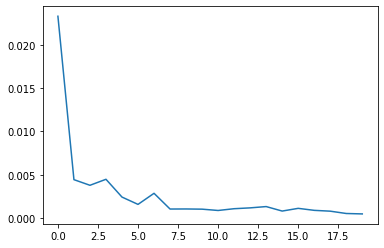

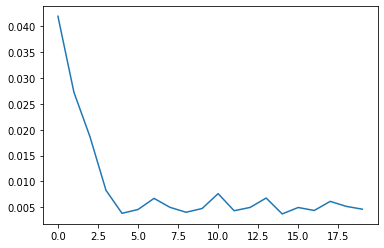

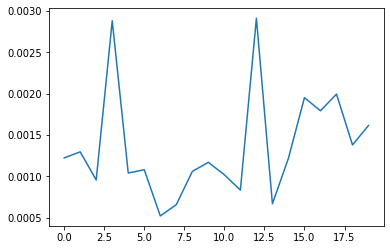

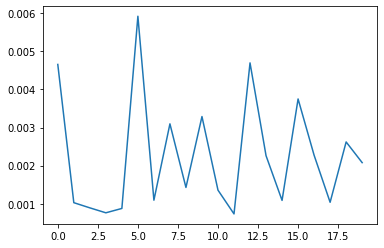

In [131]:
for llist in loss_all:
    plt.plot(llist)
    plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

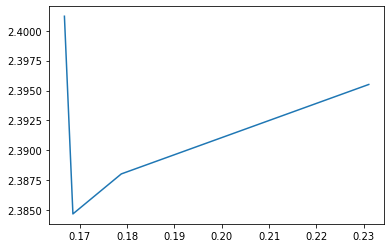

In [132]:
plt.plot([x[0] for x in params], [x[1] for x in params])
plt.show

In [133]:
print(params)

[(0.23104966726029524, 2.3955079349565085), (0.17880082382690762, 2.3880366982152035), (0.16858761524991553, 2.384696677704515), (0.16679391434111474, 2.4012046676300383)]


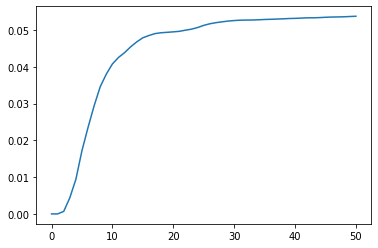

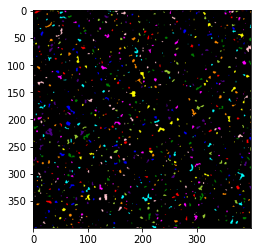

In [134]:
noise = generate_noise_array(size, threshold=0.3, smooth=1.5, amount=1)
F_noise, G_noise = analyse_video(noise, L=50)
plt.plot(np.mean([i / j for i, j in zip(F_noise, G_noise)], axis=0))
plt.show()

plt.imshow(label2rgb(noise[0]))
plt.show()

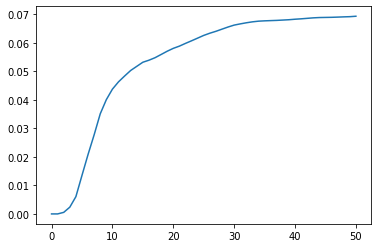

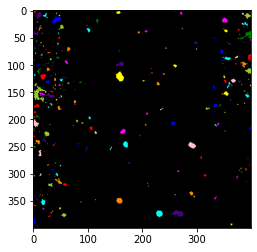

In [135]:
plt.plot(F/G)
plt.show()

plt.imshow(label2rgb(im[0]))
plt.show()

In [136]:
# def stochastic_loss(thresh, disk):
#     noise = generate_noise(size=size, threshold=thresh, disk_size=disk, amount=4)
#     res_list = stochastic_analyse_video(noise, L=50)
#     return np.mean([(i[0] - y[i[1]])**2 for i in res_list])